In [1]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(42)

n_points = 600
time = np.arange(n_points)


X1 = np.random.binomial(1, 0.6, n_points)
X2 = np.zeros(n_points)
X3 = np.zeros(n_points)


for t in range(1, n_points):
    # X2 is more likely to happen if X1 happened in the previous step
    X2[t] = np.random.binomial(1, 0.5 * X1[t-1] + 0.2)
    # X3 is more likely to happen if X2 happened in the previous step
    X3[t] = np.random.binomial(1, 0.7 * X2[t-1] + 0.2)



X1 = [time[i] for i in range(len(X1)) if X1[i] > 0]
X2 = [time[i] + 0.1 for i in range(len(X2)) if X2[i] > 0]
X3 = [time[i] + 0.2 for i in range(len(X3)) if X3[i] > 0]

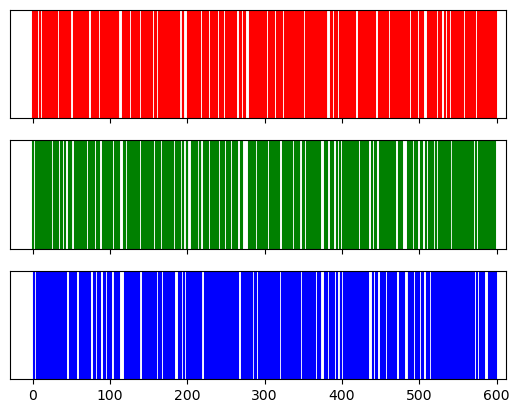

In [29]:
def _plot_tick_bars(timestamps_i, ax, color):
    for t in timestamps_i:
        ax.axvline(x=t, color = color)
    # ax.set_title(label, fontsize=20)
    ax.get_yaxis().set_visible(False)
def _plot_tick_bars_causes(timestamps_i, ax, cause):
    colors = ['red', 'green', 'blue']
    for idx, t in enumerate(timestamps_i):
        cause_ = torch.argmax(cause[idx]).item()
        ax.axvline(x=t, color = colors[cause_])
    ax.get_yaxis().set_visible(False)

fig, ax = plt.subplots(nrows = 3, sharex = True)

_plot_tick_bars(X1, ax[0], color = 'red')
_plot_tick_bars(X2, ax[1], color = 'green')
_plot_tick_bars(X3, ax[2], color = 'blue')

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
    device = "cuda"
else:
    torch.set_default_tensor_type("torch.FloatTensor")
    device = "cpu"


In [42]:
class CustomNet(nn.Module):
    def __init__(self, num_features, hidden_dim):
        super().__init__()
        
        self.embd = nn.Sequential(
            nn.Linear(num_features, hidden_dim),
            nn.Tanh())
        
        self.rnn = nn.GRU(input_size = hidden_dim, hidden_size = int(2*hidden_dim), num_layers = 2, batch_first = True)
        self.fc = nn.Linear(int(2*hidden_dim), 2*num_features)

    def forward(self, x):
        
        
        x = self.embd(x) #(10, 4, 1) -> (10, 4, 32)
        
        x, _ = self.rnn(x) # (10, 4, 32) -> (10, 4, 64)
        

        x = self.fc(x) # (10, 4, 32) -> (10, 4, 2)

        return x

model = CustomNet(num_features=1, hidden_dim=32)

x = torch.rand(size = (10, 4, 1))

model(x).shape

torch.Size([10, 4, 2])

In [62]:
coupling_ = NFBlock(num_features=1, hidden_dim=32, memory_size = 4)

# coupling_(x)[0]

In [63]:
from torch.distributions import Normal 


class AffineCouplingLayer(nn.Module):
    def __init__(self, num_features, hidden_dim, memory_size):
        super(AffineCouplingLayer, self).__init__()
        
        self.net = CustomNet(num_features=num_features, hidden_dim=hidden_dim)
        self.memory_size = memory_size
    def forward(self, x):
        mask = torch.zeros(size = (1, self.memory_size, 1))
        mask[:, :self.memory_size//2, :] = 1
        x1 = x*mask
        x2 = x*(1-mask)
        params = self.net(x1)

        shift, log_scale = params.chunk(2, dim=-1)
        shift = shift*(1-mask)
        log_scale = log_scale*(1-mask)

        z = (x + shift)*torch.exp(log_scale)
        log_det_jacobian = log_scale.sum(dim=(1,2))
        
        
        return z, log_det_jacobian

    def inverse(self, z):
        raise NotImplemented
        # z1, z2 = z.chunk(2, dim=1)
        # params = self.net(z1)
        # shift, log_scale = params.chunk(2, dim=1)
        # x2 = z2 * torch.exp(log_scale) + shift
        # x = torch.cat([z1, x2], dim=1)
        
        # return x

class InvConv1D(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        # Initialize an orthogonal matrix for 1x1 convolution in 1D
        w_init, _ = torch.linalg.qr(torch.randn(num_features, num_features))
        #w_init = torch.tensor(w_init)

        self.register_buffer('w', w_init)
        self.w_inverse = None

    def forward(self, x):
        # x is of shape (batch_size, num_features)
        # Apply the learned 1x1 convolution (linear transformation)
        z = self.w @ x  # Matrix multiplication for 1D

        # Compute log determinant of the Jacobian for the flow
        log_det_jacobian = torch.slogdet(self.w)[1]
        
        return z, log_det_jacobian

    def inverse(self, z):
        if self.w_inverse is None:
            self.w_inverse = torch.inverse(self.w)
        x = self.w_inverse @ z
        
        return x



class NFBlock(nn.Module):
    def __init__(self, num_features, hidden_dim, memory_size):
        super().__init__()
        self.invertible_conv = InvConv1D(memory_size)
        self.affine_coupling = AffineCouplingLayer(num_features = num_features, hidden_dim = hidden_dim, memory_size = memory_size)

    def forward(self, x):
        z, log_det_jacobian_conv = self.invertible_conv(x)
        
        z, log_det_jacobian_affine = self.affine_coupling(z)
        
        log_det_jacobian = log_det_jacobian_conv + log_det_jacobian_affine
        
        return z, log_det_jacobian

    def inverse(self, z):
        x = self.affine_coupling.inverse(z)
        x = self.invertible_conv.inverse(x)
        
        return x



class NormalizingFlow(nn.Module):
    def __init__(self, num_features, memory_size, hidden_dim, num_layers):
        super(NormalizingFlow, self).__init__()
        self.num_features = num_features
        self.memory_size = memory_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.base_dist = Normal(0, 1)
        self.blocks = nn.ModuleList(
            [NFBlock(num_features = num_features, memory_size = memory_size, hidden_dim = hidden_dim) for _ in range(num_layers)]
        )
        
    
    def forward(self, x):
        log_det_jacobian = 0
        
        for layer in self.blocks:
            x, ldj = layer(x)
            log_det_jacobian += ldj
        
        return x, log_det_jacobian

    def inverse(self, z):
        for layer in reversed(self.blocks):
            z = layer.inverse(z)
        return z


    def log_prob(self, x):
        z, ldj = self.forward(x)
        log_pz = self.base_dist.log_prob(z).sum(dim = (1,2))
        log_px = log_pz + ldj

        return z, log_px



In [69]:
model = NormalizingFlow(memory_size=4, num_features=1, hidden_dim = 64, num_layers=3)
# model = CustomNet(num_features=1, hidden_dim=32, memory_dim = 4)

x = torch.rand(size = (10, 4, 1))

model(x)[0].shape

torch.Size([10, 4, 1])

In [79]:
class GrangerMPP(nn.Module):

    def __init__(self, processes, memory_dim : int = 10):

        super().__init__()

        self.processes = processes
        self.memory_dim = memory_dim
        self.n_processes = len(self.processes)

        self.GrangerMatrix = nn.Parameter((torch.empty(self.n_processes, self.n_processes)))
        nn.init.normal_(self.GrangerMatrix, mean=0.5, std=0.1) # very important

        self.models = nn.ModuleList([NormalizingFlow(num_features = 1, memory_size = self.memory_dim, hidden_dim = 32, num_layers = 4) for i in range(self.n_processes)])
        self.sweep_dict = self.make_sweep_dict()
        self.time_of_start = self.get_time_of_start()
        self.optimizers = [torch.optim.Adam(list(self.models[i].parameters()), lr=1e-4, weight_decay = 1e-5) for i in range(self.n_processes)]
        self.g_optimizer = torch.optim.Adam([self.GrangerMatrix], lr = 1e-3, weight_decay=1e-5)
        self.log_GrangerMatrix = []


    def em_step(self, n_steps):
        
        dic = {}
        self.causes = [[], [], []]
        for i in range(self.n_processes):
            dic[i] = []


        taus = torch.linspace(1, 0.5, steps = n_steps)#
        
        for self.step in range(n_steps):
          for i_proc in range(self.n_processes):
              self.causes[i_proc] = []
              curr = processes[i_proc]
              len_curr = len(curr)
              idx_start = 0
              while idx_start < len_curr:
                self.num_events = 5
                events = self.get_events(self.num_events, idx_start, i_proc, 1.0) ## the get_events does the e_step!
                if events:
                  DL = DataLoader(events, batch_size = len(events))

                  for X, cause_rank in DL:
                    X = X.unsqueeze(-1)
                    loss = self.m_step(i_proc, X, cause_rank)
                    dic[i_proc].append(loss)

                idx_start += self.num_events

              if (self.step + 1) % 5 == 0 or self.step == 0:
                  print(f'Step: {self.step + 1}, Model: {i_proc}, Loss: {loss}')


        return dic

    def m_step(self, i_proc, X, cause_rank):

        model = self.models[i_proc]
        self.optimizers[i_proc].zero_grad()
        self.g_optimizer.zero_grad()
        z, logp = model.log_prob(X)
        loss = -1*logp

        loss_rnn = (loss * cause_rank).sum()  + -1*(torch.log(cause_rank + 1e-7)).sum() + 0.001*self.GrangerMatrix[i_proc].norm(p=1)


        if not (torch.isnan(loss_rnn) | torch.isinf(loss_rnn)):


            loss_rnn.backward(retain_graph = True)

            self.optimizers[i_proc].step()
            self.g_optimizer.step()
            self.log_GrangerMatrix.append(self.GrangerMatrix.clone().detach())


        else:
            print(f'NaN found in epoch: {self.step}')

        return loss_rnn.item()

    def make_sweep_dict(self):

        dic = {}
        for i in range(self.n_processes):
            target = self.processes[i]
            dic[i] = {}
            for j in range(self.n_processes):
                cause = self.processes[j]
                dic[i][j] = self.sweep(target, cause)

        return dic


    def sweep(self, pa, pc):
        events = []
        pa_indices = []


        for i, ia in enumerate(pa):
            events.append((ia, 'a'))
            pa_indices.append(i)

        for ic in pc:
            events.append((ic, 'c'))

        lim = self.memory_dim

        events.sort()
        mem = []
        ret = []
        index_start = False

        pa_idx_counter = 0  # Counter to track which index in pa we are at

        for t, e in events:
            if e == 'c':
                if len(mem) >= lim:
                    mem.pop(0)
                mem.append(t)

            if e == 'a':
                # Memory is not full yet
                if len(mem) < lim:
                    pa_idx_counter += 1  # Move to the next pa index
                    continue
                # Retrieve deltas from this time to the cause times
                pp = [t - tc for tc in mem]
                ret.append(pp)
                if not index_start:
                  index_start = pa_indices[pa_idx_counter] # Save index relative to pa
                pa_idx_counter += 1  # Move to the next pa index
        if not index_start:
          index_start = -1
        return torch.tensor(ret, dtype=torch.float), index_start

    def get_time_of_start(self):

      indexs = []
      dic = self.sweep_dict

      for i in dic:
        curr = []
        for j in dic[i]:
          curr.append(dic[i][j][1])
        indexs.append(curr)

      return indexs


    def new_e_step(self, num_events, i_proc, tau):

      in_ = self.GrangerMatrix[i_proc]#.softmax(dim = 0)
      rv = []
      for i in range(num_events):
        cause = F.gumbel_softmax(
            in_,
            tau = tau,
            hard = False
        )
        rv.append(cause)

      self.causes[i_proc].append(rv)

      return rv


    def get_events(self, num_events, idx_start, i_proc, tau):

      begin_of_influences = self.time_of_start[i_proc]
      n_causes = self.new_e_step(num_events, i_proc, tau)

      event_cause = []

      for time in range(num_events):
        causes = n_causes[time]

        for idx_cause, cause in enumerate(causes):
          inf_begin = begin_of_influences[idx_cause]

          if inf_begin == -1: ## this process cannot be caused by this other process (it started after the current process ended)
            continue

          else:
            if time + idx_start >= inf_begin and len(self.sweep_dict[i_proc][idx_cause][0]) > time + idx_start + inf_begin: ## checking if the current_timestamp could be cause by the process and if there's events pass this time
              app = (self.sweep_dict[i_proc][idx_cause][0][time + idx_start - inf_begin], cause)
              event_cause.append(app)

      return event_cause



In [80]:
X1_ = torch.tensor(X1.copy(), dtype = torch.float32)
X2_ = torch.tensor(X2.copy(), dtype = torch.float32)
X3_ = torch.tensor(X3.copy(), dtype = torch.float32)
processes = [X1_, X2_, X3_]

In [81]:
mpp = GrangerMPP(processes, memory_dim = 4)
l = mpp.em_step(n_steps = 200)

Step: 1, Model: 0, Loss: 3.230762004852295
Step: 1, Model: 1, Loss: 7.036431789398193
Step: 1, Model: 2, Loss: 5.593333721160889
Step: 5, Model: 0, Loss: 4.4627227783203125
Step: 5, Model: 1, Loss: 6.570101737976074
Step: 5, Model: 2, Loss: 3.2197797298431396
Step: 10, Model: 0, Loss: 3.2939653396606445
Step: 10, Model: 1, Loss: 6.67199182510376
Step: 10, Model: 2, Loss: 4.139893054962158
Step: 15, Model: 0, Loss: 2.972224712371826
Step: 15, Model: 1, Loss: 8.785547256469727
Step: 15, Model: 2, Loss: 4.817923069000244
Step: 20, Model: 0, Loss: 4.563640117645264
Step: 20, Model: 1, Loss: 5.890956878662109
Step: 20, Model: 2, Loss: 3.6408960819244385
Step: 25, Model: 0, Loss: 3.029003381729126
Step: 25, Model: 1, Loss: 6.428956508636475
Step: 25, Model: 2, Loss: 2.7498672008514404
Step: 30, Model: 0, Loss: 2.7275729179382324
Step: 30, Model: 1, Loss: 5.6038384437561035
Step: 30, Model: 2, Loss: 3.1044259071350098
Step: 35, Model: 0, Loss: 2.679438352584839
Step: 35, Model: 1, Loss: 5.717

Len of losses: [13800, 12000, 13200]


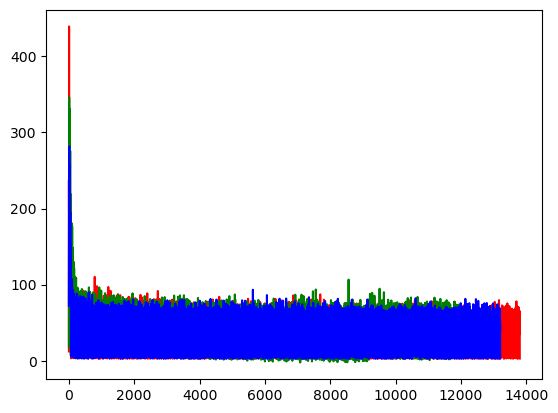

In [82]:
colors = ['red', 'green', 'blue']
for i in range(3):
    plt.plot(l[i], color = colors[i])

t = [len(l[i]) for i in range(3)]

print(f'Len of losses: {t}')

In [99]:
# mpp.models

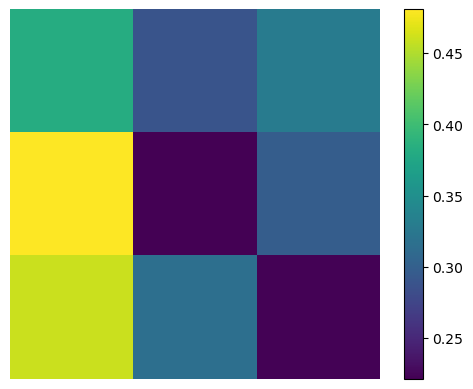

In [83]:
matrix = mpp.GrangerMatrix.softmax(dim = 1).detach().cpu().numpy()

plt.imshow(matrix)
plt.axis('off')
plt.colorbar()

In [78]:
mpp.GrangerMatrix.softmax(dim = 1).detach().cpu().numpy()

array([[0.36727107, 0.290403  , 0.34232584],
       [0.4683476 , 0.24563067, 0.28602168],
       [0.38287362, 0.32714796, 0.28997844]], dtype=float32)

In [180]:
len(processes[1])

167

In [101]:
mpp.GrangerMatrix.detach().cpu().numpy()

array([[ 0.6786759 , -0.05376524,  0.89782923],
       [ 0.8750847 ,  0.10535194,  0.42755637],
       [ 0.83915406,  0.14972755,  0.23933211]], dtype=float32)

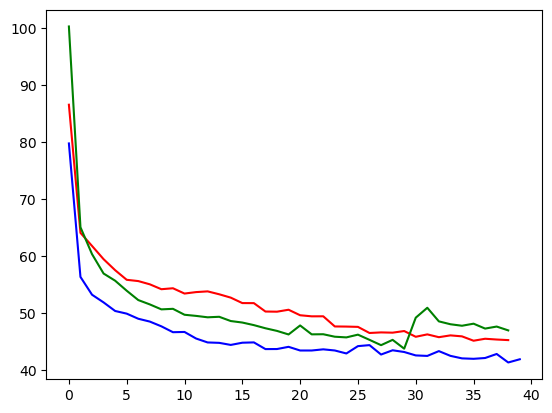

In [84]:
final = []
for proc in range(3):
    proc_size = len(processes[proc])
    loss_size = len(l[proc])
    temp = [ sum(l[proc][i:i + proc_size])/proc_size for i in range(0, loss_size - proc_size, proc_size)]
    final.append(temp)

colors = ['red', 'green', 'blue']
for i in range(3):
    plt.plot(final[i], color = colors[i])

In [158]:
temp

[905.976876769747, 824.3470450299127, 720.2255801473345]

In [74]:
s = [i.argmax().item() for i in mpp.causes[0]]
s = torch.tensor(s)
s.unique(return_counts = True)

AttributeError: 'list' object has no attribute 'argmax'

In [79]:
causes = []
for i in mpp.causes[0]:
    for j in i:
        causes.append(j.argmax().item())
causes = torch.tensor(causes)
causes.unique(return_counts = True)

(tensor([0, 1, 2]), tensor([112, 125, 112]))